In [1]:
%reset -f
import time
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate
from scipy.integrate import solve_bvp

# from tueplots.bundles import probnum2025
# plt.rcParams.update(probnum2025())


### 0. Solutions to the TOV-Equations and Source/Matter Terms

In [2]:
# Load the variables from tov-final
r_o   = 1.0e+3          # outer radius (maximum radius)
r_c   = 1.0e-1          # central radius (minimum radius)
P_c   = 1.0e-1          # central pressure (maximal pressure)

# Note: the value for the central pressure must be sufficiently low as to avoid having to deal with singularities (visible in alpha, psi)

# Specify and load the file
filename    = f'../data/tov_{round(np.log10(r_o)):+}{round(np.log10(r_c)):+}{round(np.log10(P_c)):+}.npy'
loaded_data = np.load(filename)

# Unpack the values
r, m, P, rho, R, alpha, psi = loaded_data

# Define polytropic constants (using c = G = 1 units for simplicity)
K     = 100    # Polytropic constant
Gamma = 2      # Polytropic exponent

# Polytropic Equation of State (EOS)
def pressure(rho):
    return K * rho**Gamma

downsample_factor = 10000
m     = m[::downsample_factor]
P     = P[::downsample_factor]
rho   = rho[::downsample_factor]
R     = R[::downsample_factor]
alpha = alpha[::downsample_factor]
psi   = psi[::downsample_factor]

# Express the source/matter terms
W  = 1                                         # Lorentz factor
v  = np.zeros_like(rho)                        # radial velocity

E  = rho
Sr = rho * (1 + P/rho) * W**2 * v
S  = rho * (1 + P/rho) * W**2 * v**2 + 3 * P


## 1. Application of a perturbation to the density

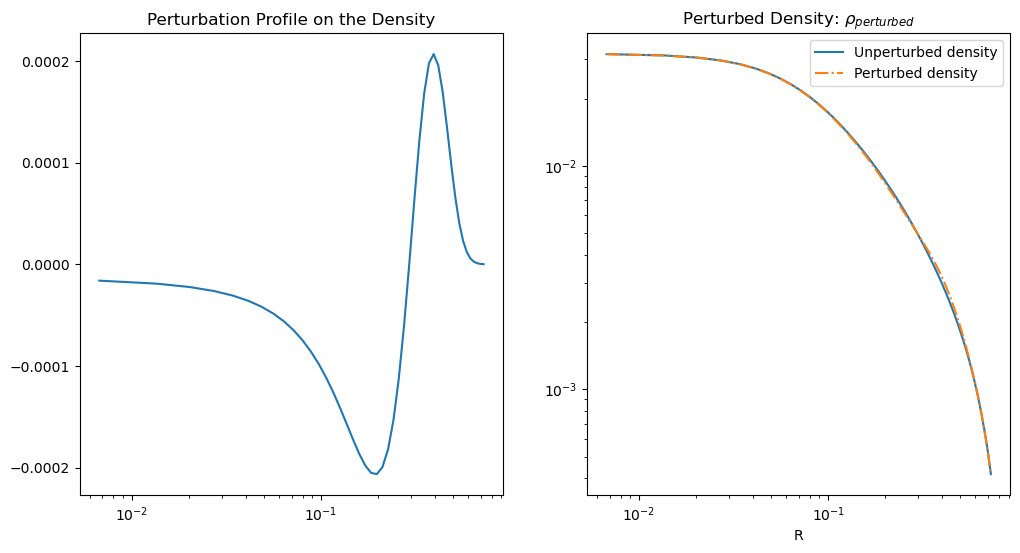

In [3]:
# Perturbation parameters
center_value  = 0.3        # Center value
sigma         = 1.0e-1     # Width of the full Gaussian
amplitude     = 1.0e-3     # Scale factor

# Center Gaussian
center_index  = np.argmin(np.abs(R - center_value))
R_centered    = (R - R[center_index])/R[center_index]
gaussian      = amplitude * np.exp(-((R - R[center_index]) ** 2) / (2 * sigma**2))

# Multiplication of Gaussian with shifted R-axis
perturbation  = gaussian * R_centered
rho_perturbed = rho + gaussian * R_centered

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(R, perturbation)
ax[0].set_xscale('log')
ax[0].set_title("Perturbation Profile on the Density")

ax[1].plot(R, rho, label="Unperturbed density");
ax[1].plot(R, rho_perturbed, linestyle='-.', label="Perturbed density");
ax[1].set_xlabel('R');
ax[1].set_xscale('log');
ax[1].set_yscale('log');250
ax[1].set_title(r"Perturbed Density: $\rho_{perturbed}$");
ax[1].legend();


### 2. Problem Definition

In [4]:
# Apply the density perturbation of the source/matter terms
E_perturbed  = rho_perturbed
Sr_perturbed = rho_perturbed * (1 + P/rho) * W**2 * v
S_perturbed  = rho * (1 + pressure(rho_perturbed)/rho) * W**2 * v**2 + 3 * pressure(rho_perturbed)


Given the perturbation on the density, the vector equations are trivially zero.

We focus on the the first scalar ODE to solve is:

\begin{equation}
\left(\nabla^{2} + S_{1} / \psi^{2} + 7 S_{7} / \psi^{8} \right) \delta \psi = \delta S_{1} / \psi + \delta S_{7} / \psi^{7}
\end{equation}
in which 
\begin{align}
    S_1   &= -2 \pi \rho_{perturbed} \\ 
    \delta S_1 &= - 2 \pi \delta \rho \\
    S_7   &= 0 \\
    \delta S_7 &= 0
\end{align}

We can define $\tilde{k}^{2}_{\psi} = -S_{1} /  \psi^{2} - 7 S_{7} / \psi^{8}$ such that the scalar ODE becomes:
\begin{equation}
    \left(\nabla^{2} - \tilde{k}^{2}_{\psi} \right) \ \delta \psi = \delta S_{1} / \psi + \delta S_{7} / \psi^{7}
\end{equation}
Only considering nonzero functions and defining $k^2_{\psi} = - S_{1} / \psi^{2}$ yields:
\begin{equation}
    \left(\nabla^{2} - k^{2}_{\psi} \right) \ \delta \psi = \delta S_{1} / \psi
\end{equation}
The boundary conditions are:
\begin{align}
    \frac{d \delta \psi}{dr}(0) &= 0 \\
    \delta \psi(R) &= 0
\end{align}

In [5]:
# Upper bound of the integration domain
R_min_num = np.min(R)
R_max_num = np.max(R)

# Definition of S1, k_squared
S1           = - 2*np.pi*rho_perturbed
k_squared1   = - S1/psi**(2)

# Definition of source term
dS1          = -2*np.pi*perturbation
source_term1 = dS1/psi


Considering a spherical coordinate system and spherical symmetry, we obtain:
\begin{align}
    \partial_{r}^{2} \big(r f(r)\big)
    \, - \,
    k^{2}(r) \, r f(r)
    \ = \
    r \, b(r) 
\end{align}
with the boundary conditions:
\begin{align}
    \frac{df}{dr}(0) &= 0 \\
    f(R) &= 0
\end{align}
by defining $rf(r) \equiv u(r)$, we obtain:
\begin{align}
    \partial_{r}^{2} \big(u(r)\big)
    \, - \,
    k^{2}(r) \, u(r)
    \ = \
    r \, b(r) 
\end{align}
with the boundary conditions:
\begin{align}
    \frac{d^2u}{dr^2}(0) &= 0 \\
    u(R) &= 0
\end{align}
The transformed boundary condition at $r=0$ originates from the following expansion of $u(r)$:
\begin{equation}
    u(r) = u(0) + u'(0)r + \frac{1}{2}u''(0)r^2 + \frac{1}{6}u^{(3)}(0)r^3 + ...
\end{equation}
Since $u(r)$ cannot diverge at $r=0$, we require that $u(0) = 0$, such that the expansion of $u(r)$ becomes:
\begin{equation}
    u(r) = u'(0)r + \frac{1}{2}u''(0)r^2 + \frac{1}{6}u^{(3)}(0)r^3 + ...
\end{equation}
The expansion of $f(r)$ is thus:
\begin{equation}
    f(r) = u'(0) + \frac{1}{2}u''(0)r + \frac{1}{6}u^{(3)}(0)r^2 + ...
\end{equation}
Taking the derivative yields:
\begin{equation}
    f(r) = \frac{1}{2}u''(0) + \frac{1}{3}u^{(3)}(0)r + ...
\end{equation}
The original boundary condition that $\frac{df}{dr}(0) = 0$ thus implies:
\begin{equation}
    u''(0) = 0
\end{equation}
As $u(0) = 0$ and $u''(0)=0$, the expansion of $u(r)$ near the origin is:
\begin{equation}
    u(r) = u(0) + u'(0)r + \frac{1}{2}u''(0)r^2 \approx u'(0)r
\end{equation}

### 3. Classical Numerical Solution

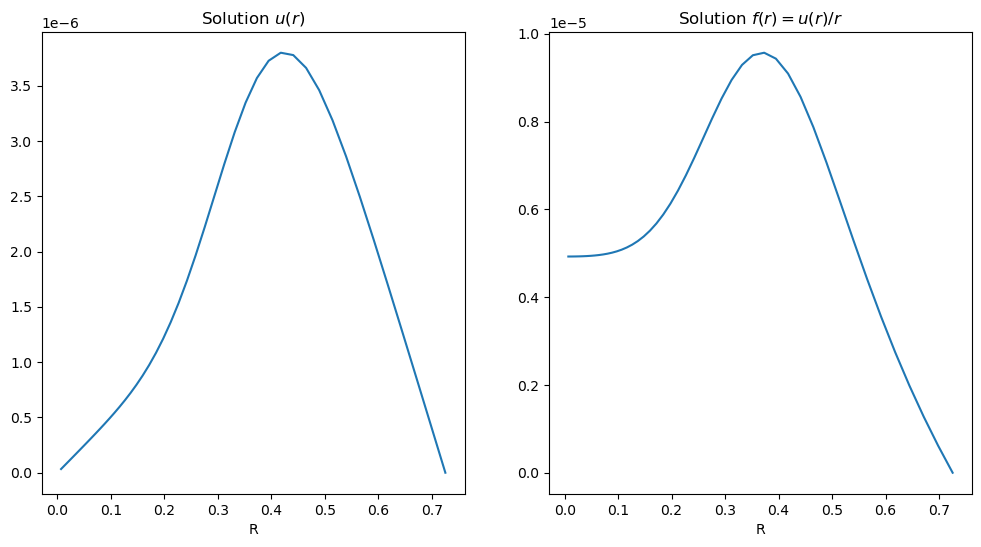

In [6]:
# Interpolate the numerically determined functions
k_squared_interp   = interpolate.interp1d(R, k_squared1,   kind='cubic', bounds_error=False, fill_value='extrapolate')
source_term1_interp = interpolate.interp1d(R, source_term1, kind='cubic', bounds_error=False, fill_value='extrapolate')

# Conversion of the 2nd order ODE to a 1st order system of ODEs defining a state vector y such that y[0] = u, and y[1] = du/dr
def fun(r, y):
    u   = y[0]
    du  = y[1]
    ddu = k_squared_interp(r) * u + r * source_term1_interp(r)
    return np.vstack((du, ddu))

# Define the boundary conditions:
def bc(ya, yb):
    r0 = r_domain[0]  # first grid point, e.g. 0.005
    return np.array([ya[0] - r0 * ya[1],  # inner BC: u(r0) - r0*u'(r0)=0
                     yb[0]             ])  # outer BC: u(R) = 0

# Define the domain
r_domain = R

# Initial guess for solution y: two components, u and du/dr
y_guess  = np.zeros((2, r_domain.size))

# Solve BVP
sol = solve_bvp(fun, bc, r_domain, y_guess)

# Recover f(r) = u(r)/r
u = sol.y[0]
f = u / r_domain

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(R, u)
ax[0].set_xlabel('R');
ax[0].set_title(r"Solution $u(r)$")

ax[1].plot(R, f);
ax[1].set_xlabel('R');
ax[1].set_title(r"Solution $f(r) = u(r)/r$");


### 4. Probabilistic Numerical Solution

We can also directly solve the equation in $f(r)$:
\begin{align}
    \bigg( \partial_{r}^{2} + \frac{2}{r} \partial_r - k^2(r) \bigg) f(r) = b(r)
\end{align}
with the boundary conditions:
\begin{align}
    \frac{df}{dr}(0) &= 0 \\
    f(R) &= 0
\end{align}

10
20
30
40


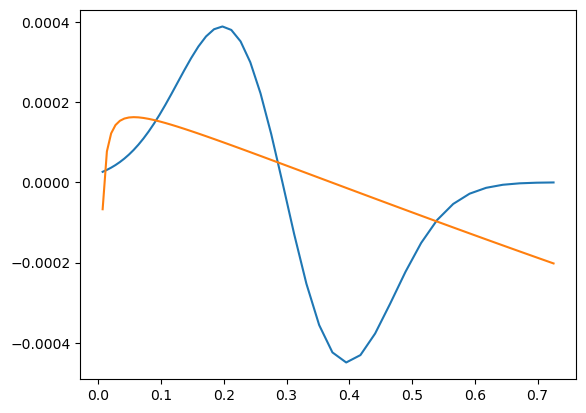

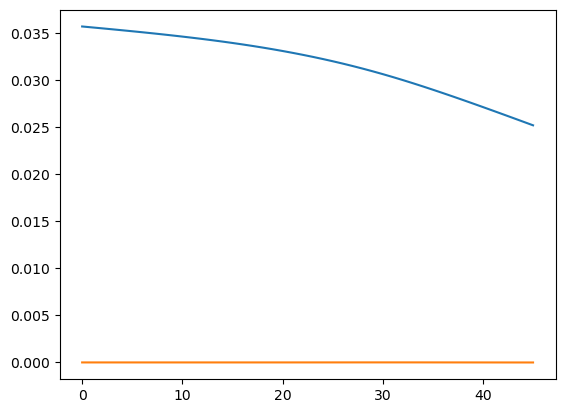

In [7]:
# Symbol nomenclature
r     = sp.symbols('r')
rp    = sp.symbols('rp')

# Define the kernel function
sigma_f = 1e-2
l_f     = 5
k       = (sigma_f**2)*sp.exp(-(r-rp)**2/(2*l_f**2))

# Specificy the problem as: L f = g
L_operator = lambda r, func: sp.diff(func, r, 2) + 2/r*sp.diff(func, r)
source_obs  = source_term1_interp(r_domain)

# Matrix initialization
K_LL  = np.zeros((len(r_domain), len(r_domain)))
K_LB1 = np.zeros((len(r_domain), 1))
K_LB1_test = np.zeros((len(r_domain), 1))
K_LB2 = np.zeros((len(r_domain), 1))

# Boundary condition 1: dphi(r=0)/dr = 0
# Boundary condition 2: phi(r=R)     = 0

previous_i = 0
for i, ri in enumerate(r_domain):

    K_LB1[i] = sp.lambdify([r, rp], sp.diff(L_operator(r, k), rp))(ri, R_min_num) - k_squared_interp(ri)*sp.lambdify([r, rp], sp.diff(k, rp))(ri, R_min_num)
    K_LB2[i] = sp.lambdify([r, rp], L_operator(r, k))(ri, R_max_num) - k_squared_interp(ri)*sp.lambdify([r, rp], k)(ri, R_min_num)

    for j, rj in enumerate(r_domain):
        
        K_LL[i, j] = sp.lambdify([r, rp], L_operator(rp, L_operator(r, k)))(ri, rj) - sp.lambdify([r, rp], L_operator(r, k))(ri, rj)*k_squared_interp(rj) - sp.lambdify([r, rp], L_operator(rp, k))(ri, rj)*k_squared_interp(ri) + k_squared_interp(ri)*k_squared_interp(rj)*sp.lambdify([r, rp], k)(ri, rj)        
        
        # Keep track of the progress through print statements:
        if (i != previous_i):
            if (i%10 == 0):
                print(i)
                previous_i = i

K_B1L = K_LB1.T
K_B2L = K_LB2.T
            
K_B1B1 = sp.lambdify([r, rp], sp.diff(sp.diff(k, rp), r))(min(r_domain), min(r_domain))   
K_B1B2 = sp.lambdify([r, rp], sp.diff(k, r))(min(r_domain), max(r_domain))
K_B2B1 = K_B1B2
K_B2B2 = sp.lambdify([r, rp], k)(max(r_domain), max(r_domain))

K = np.block([
    [K_LL,    K_LB1,  K_LB2],
    [K_LB1.T, K_B1B1, K_B1B2],
    [K_LB2.T, K_B1B2, K_B2B2],
])

# Mesh evaluation
S = 1.0e-4*np.identity(len(r_domain) + 2)
S[-1,-1] = 10**(-4)
S[-2,-2] = 10**(-4)

# Source term
g = source_term1_interp(r_domain)
g = np.hstack((g, np.squeeze(np.zeros((2,1)))))

# Solve the system of equations
alpha = np.linalg.solve(K + np.linalg.matrix_power(S,2), g)

# Source functin approximation
source_func_mean_kernel = K @ alpha

# Approximation
plt.plot(r_domain, g[:-2])
plt.plot(r_domain, source_func_mean_kernel[:-2])

# Matrix construction
A1, A2 = np.meshgrid(r_domain, r_domain, indexing='ij')
ks11 = sp.lambdify([r, rp], k)(A1, A2)
ks12 = np.atleast_2d(sp.lambdify([r, rp], sp.diff(k, rp))(r_domain, R_min_num))
ks13 = np.atleast_2d(sp.lambdify([r, rp], k)(r_domain, R_max_num))
Ks = np.block([[ks11,   ks12.T,   ks13.T]])

# Solution approximation
solution_mean_kernel = Ks @ alpha

plt.figure(2)
plt.plot(solution_mean_kernel)
plt.plot(f)


Considering a spherical coordinate system and spherical symmetry, we obtain:
\begin{align}
    \partial_{r}^{2} \big(r f(r)\big)
    \, - \,
    k^{2}(r) \, r f(r)
    \ = \
    r \, b(r) 
\end{align}
with the boundary conditions:
\begin{align}
    \frac{df}{dr}(0) &= 0 \\
    f(R) &= 0
\end{align}
by defining $rf(r) \equiv u(r)$, we obtain:
\begin{align}
    \partial_{r}^{2} \big(u(r)\big)
    \, - \,
    k^{2}(r) \, u(r)
    \ = \
    r \, b(r) 
\end{align}
with the boundary conditions:
\begin{align}
    u(r_{min}) - r_{min}\frac{du(r_{min})}{dr} &= 0 \\
    u(R) &= 0
\end{align}

2.2530651092529297


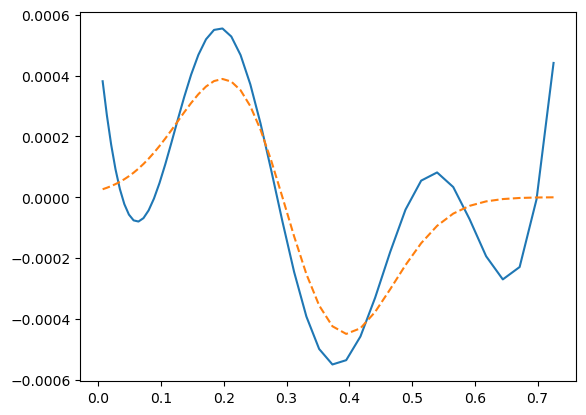

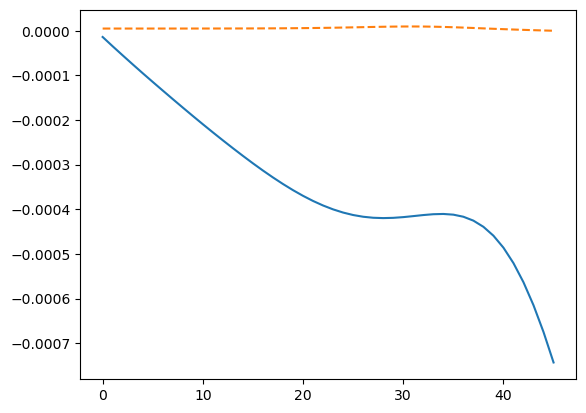

In [37]:
# Symbol nomenclature
r     = sp.symbols('r')
rp    = sp.symbols('rp')

# Define the kernel function
sigma_f = 1
l_f     = 1
k       = (sigma_f**2)*sp.exp(-(r-rp)**2/(2*l_f**2))
nu      = 5/2
rho     = 0.5
# gamma   = sp.functions.special.gamma_functions.gamma(np.sqrt(2*nu))
# k       = sigma_f**2*2**(1-nu)/gamma*(np.sqrt(2*nu)*(r-rp)**2/rho)**(nu)*sp.functions.special.bessel.besselk(nu, np.sqrt(2*nu)*(r -rp)**2/rho)
k       = sigma_f**2*(1 + sp.sqrt(5)*(r-rp)**2/rho + 5*(r-rp)**2/(3*rho**2))*sp.exp(-sp.sqrt(5)*(r-rp)**2/rho)


# Specificy the problem as: L f = g
L_operator = lambda r, func: sp.diff(func, r, 2)
source_obs  = r_domain*source_term1_interp(r_domain)

# Matrix initialization
K_LL  = np.zeros((len(r_domain), len(r_domain)))
K_LB1 = np.zeros((len(r_domain), 1))
K_LB1_test = np.zeros((len(r_domain), 1))
K_LB2 = np.zeros((len(r_domain), 1))

# Boundary condition 1: dphi(r=0)/dr = 0
# Boundary condition 2: phi(r=R)     = 0

# Precompute the parts of the kernel:
k_LB1_part1 = sp.lambdify([r, rp], k - rp*sp.diff(L_operator(r, k), rp))
k_LB1_part2 = sp.lambdify([r, rp], k - rp*sp.diff(k, rp))
k_LB2_part1 = sp.lambdify([r, rp], L_operator(r, k))
k_LB2_part2 = sp.lambdify([r, rp], k)

k_LL_part1  = sp.lambdify([r, rp], L_operator(rp, L_operator(r, k)))
k_LL_part2  = sp.lambdify([r, rp], L_operator(r, k))
k_LL_part3  = sp.lambdify([r, rp], L_operator(rp, k))

previous_i = 0
time_start = time.time()
for i, ri in enumerate(r_domain):

    K_LB1[i] = k_LB1_part1(ri, R_min_num) - k_squared_interp(ri)*k_LB1_part2(ri, R_min_num)
    K_LB2[i] = k_LB2_part1(ri, R_max_num) - k_squared_interp(ri)*k_LB2_part2(ri, R_min_num)

    for j, rj in enumerate(r_domain):
        K_LL[i, j] = k_LL_part1(ri, rj) - k_LL_part1(ri, rj)*k_squared_interp(rj) - k_LL_part3(ri, rj)*k_squared_interp(ri) + k_squared_interp(ri)*k_squared_interp(rj)*sp.lambdify([r, rp], k)(ri, rj)        
        
K_B1L = K_LB1.T
K_B2L = K_LB2.T
            
K_B1B1 = sp.lambdify([r, rp], k - r*sp.diff(k - r*sp.diff(k, rp), r))(min(r_domain), min(r_domain))   
K_B1B2 = sp.lambdify([r, rp], k - r*sp.diff(k, r))(min(r_domain), max(r_domain))
K_B2B1 = K_B1B2
K_B2B2 = sp.lambdify([r, rp], k)(max(r_domain), max(r_domain))

K = np.block([
    [K_LL,    K_LB1,  K_LB2],
    [K_LB1.T, K_B1B1, K_B1B2],
    [K_LB2.T, K_B1B2, K_B2B2],
])

time_stop = time.time()

# Mesh evaluation
S = 1*np.identity(len(r_domain) + 2)
S[-1,-1] = 10**(-1)
S[-2,-2] = 10**(-1)

# Source term
g = source_term1_interp(r_domain)
g = np.hstack((g, np.squeeze(np.zeros((2,1)))))

# Solve the system of equations
alpha = np.linalg.solve(K + np.linalg.matrix_power(S,2), g)

# Source functin approximation
source_func_mean_kernel = K @ alpha

# Approximation
plt.plot(r_domain, source_func_mean_kernel[:-2])
plt.plot(r_domain, g[:-2], ls='--')

# Matrix construction
A1, A2 = np.meshgrid(r_domain, r_domain, indexing='ij')
ks11 = sp.lambdify([r, rp], k)(A1, A2)
ks12 = np.atleast_2d(sp.lambdify([r, rp], k - rp*sp.diff(k, rp))(r_domain, R_min_num))
ks13 = np.atleast_2d(sp.lambdify([r, rp], k)(r_domain, R_max_num))
Ks = np.block([[ks11,   ks12.T,   ks13.T]])

# Solution approximation
solution_mean_kernel = Ks @ alpha

plt.figure(2)
plt.plot(solution_mean_kernel)
plt.plot(f, ls='--')
print(time_stop - time_start)

1.2304386916807286e+18


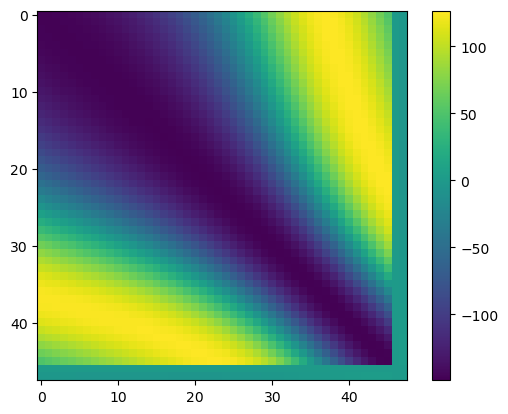

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [35]:
print(np.linalg.cond(K[1:-3,1:-3]))
eigenvals, _ = np.linalg.eig(K)
plt.imshow(K)
plt.colorbar()
plt.show()
plt.figure(3)

In [23]:
N_range   = np.arange(5, 60, 5)
rms_error = np.squeeze(np.zeros((1, len(N_range))))

for j in range(len(N_range)):
    # Define N
    N = N_range[j]
                     
    # Design matrix construction
    design_matrix = np.zeros((len(r_domain), N))
    basis_func_matrix = np.zeros((len(r_domain), N))
    
    for i in range(1, N):
        L_part_1 = sp.lambdify((r, n, R_max), sp.simplify(L_without_k_squared(r, eigenfunc)))(r_domain, i, max(r_domain))
        L_part_2 = - k_squared1_interp(r_domain)*eigenfunc_lamb(r_domain, i, max(r_domain))
    
        design_matrix[:,i] = L_part_1 + L_part_2
        basis_func_matrix[:,i] = eigenfunc_lamb(r_domain, i, max(r_domain))
    
    # Solving the system of equations
    S = 1.0e-4*np.identity(len(r_domain))
    L = np.identity(N)
    
    # Define the (inverse) squared lambda and sigma matrices
    Sneg2 = np.linalg.matrix_power(S, -2)
    Lneg2 = np.linalg.matrix_power(L, -2)
    
    # Reformulate the problem into an A @ w = b problem, and solve the least-squares (in the "classical perspective")
    A = design_matrix.T @ Sneg2 @ design_matrix + Lneg2
    b = design_matrix.T @ Sneg2 @ g
    
    # Solve the system
    w = np.linalg.solve(A, b)
    
    # Computation of the source function mean
    source_func_mean_primal = design_matrix @ w
    source_func_mean_primal = np.squeeze(source_func_mean_primal)
    
    # Computation of the source function variance
    v = np.linalg.solve(A, design_matrix.T)
    source_func_variance_primal = design_matrix @ v
    source_func_variance_primal = np.diag(source_func_variance_primal)
    
    # Computation of the solution mean
    solution_mean_primal = basis_func_matrix @ w
    solution_mean_primal = np.squeeze(solution_mean_primal)

    rms_error[j] = np.sqrt(np.mean(np.square(solution_mean_primal - f)))


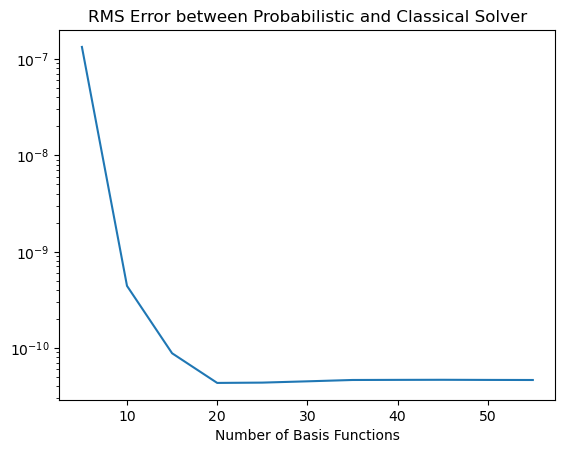

In [24]:
plt.figure
plt.plot(N_range, rms_error)
plt.yscale("log")
plt.xlabel("Number of Basis Functions");
plt.title("RMS Error between Probabilistic and Classical Solver");